# 7.6 Class design

*Estimated time for this notebook: 20 minutes*


The concepts we have introduced are common between different object oriented languages.
Thus, when we design our program using these concepts, we can think at an architectural level,
independent of language syntax.

In Python:


In [1]:
class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity

    def move(self, delta_t):
        self.position += self.velocity * delta_t

In C++:

``` cpp
class Particle {
    std::vector<double> position;
    std::vector<double> velocity;
    Particle(std::vector<double> position, std::vector<double> velocity);
    void move(double delta_t);
}
```

In Fortran:

``` fortran
type particle
    real :: position
    real :: velocity
  contains
    procedure :: init
    procedure :: move
end type particle
```

## UML


UML is a conventional diagrammatic notation used to describe "class structures" and other higher level
aspects of software design.

Computer scientists get worked up about formal correctness of UML diagrams and learning the conventions precisely.
Working programmers can still benefit from using UML to describe their designs.


## YUML

We can see a YUML model for a Particle class with `position` and `velocity` data and a `move()` method using
the [YUML](http://yuml.me/) online UML drawing tool ([example](http://yuml.me/diagram/boring/class/[Particle|position;velocity|move%28%29])).

```
    http://yuml.me/diagram/boring/class/[Particle|position;velocity|move%28%29]
```

Here's how we can use Python code to get an image back from YUML:

In [2]:
from IPython.display import SVG


def yuml(model):
    return SVG(url=f"http://yuml.me/diagram/boring/class/{model}")

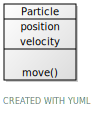

In [3]:
yuml("[Particle|position;velocity|move()]")

The representation of the `Particle` class defined above in UML is done with a box with three sections. The name of the class goes on the top, then the name of the member variables in the middle, and the name of the methods on the bottom. We will see later why this is useful.

## Information Hiding

Sometimes, our design for a program would be broken if users start messing around with variables we don't want them to change.

Robust class design requires consideration of which subroutines are intended for users to use, and which are internal.
Languages provide features to implement this: access control. 

In python, we use leading underscores to control whether member variables and methods can be accessed from outside the class:

- `_foo`: a single leading underscore (`_`) is a convention to indicate that a variable is private (ie. people are still *able* to use it but they shouldn't)
- `__foo`: a double leading underscore (`__`) is used to prevent accidental access. Inside the class the variable can be used with this name, but outside it is replaced by the interpreter with `_classname__foo`.
- `__foo__`: this pattern is used by built-in functions like `__init__` or `__str__`. You can (and should) write these for your own classes, but you should only use them for their intended purposes.

In [4]:
class MyClass:
    def __init__(self):
        self.__private_data = 0
        self._private_data = 0
        self.public_data = 0

    def __private_method(self):
        pass

    def _private_method(self):
        pass

    def public_method(self):
        pass

    def called_inside(self):
        self.__private_method()
        self._private_method()
        self.__private_data = 1
        self._private_data = 1


MyClass().called_inside()

In [5]:
MyClass()._private_method()  # Works, but forbidden by convention

In [6]:
MyClass().public_method()  # OK

print(MyClass()._private_data)

0


In [7]:
print(MyClass().public_data)

0


In [8]:
MyClass().__private_method()  # Generates error

AttributeError: 'MyClass' object has no attribute '__private_method'

In [9]:
print(MyClass().__private_data)  # Generates error

AttributeError: 'MyClass' object has no attribute '__private_data'

## Property accessors


Python provides a mechanism to make functions appear to be variables. This can be used if you want to
change the way a class is implemented without changing the interface:




In [10]:
class Person:
    def __init__(self):
        self.name = "John Watson"


Person().name

'John Watson'




becomes:




In [11]:
class Person:
    def __init__(self):
        self._first = "John"
        self._second = "Watson"

    @property
    def name(self):
        return f"{self._first} {self._second}"


Person().name

'John Watson'

Making the same external code work as before.




Note that the code behaves the same way to the outside user.
The implementation detail is hidden by private variables.
In languages without this feature, such as C++, it is best to always
make data private, and always
access data through functions:




In [12]:
class Person:
    def __init__(self):
        self._name = "John Watson"

    def name(self):  # an access function
        return self._name


Person().name()

'John Watson'

But in Python this is unnecessary because the `@property` capability.


Another way could be to create a member variable `name` which holds the full name. However, this could lead to inconsistent data. If we create a `get_married` function, then the name of the person won't change!

In [13]:
class Person:
    def __init__(self, first, second):
        self._first_ = first
        self._second_ = second
        self.name = f"{self._first_} {self._second_}"

    def get_married(self, to):
        self._second_ = f"{self._second_}-{to._second_}"

In [14]:
john = Person("John", "Watson")
john.name

'John Watson'

In [15]:
sherlock = Person("Sherlock", "Holmes")
john.get_married(sherlock)

john._second_

'Watson-Holmes'

In [16]:
john.name  # Not John Watson-Holmes?

'John Watson'

This type of situation could makes that the object data structure gets inconsistent with itself. Making variables being out of sync with other variables. Each piece of information should only be stored in once place! In this case, `name` should be calculated each time it's required as previously shown.
In database design, this is called [Normalisation](https://en.wikipedia.org/wiki/Database_normalization).

### UML for private/public

We prepend a `+`/`-` on public/private member variables and methods:

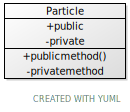

In [17]:
yuml("[Particle|+public;-private|+publicmethod();-privatemethod]")

## Class Members


*Class*, or *static* members, belong to the class as a whole, and are shared between instances.

This is an object that keeps a count on how many have been created of it.


In [18]:
class Counted:
    number_created = 0  # this is shared between all instances of Counted

    def __init__(self):
        # Increment the class-level variable 'number_created'
        Counted.number_created += 1
        # Add a member variable: each instance of Counted has its own version of 'local_variable'
        self.local_variable = 5

    @classmethod
    def howMany(cls):
        return cls.number_created


Counted.howMany()

0

In [19]:
x = Counted()
Counted.howMany()

1

In [20]:
z = [Counted() for x in range(5)]
Counted.howMany()

6

In [21]:
x.howMany()

6

The data is shared among all the objects instantiated from that class. Note that in `__init__` we are not using `self.number_created` but the name of the class. The `howMany` function is not a method of a particular object. It's called on the class, not on the object. This is possible by using the `@classmethod` decorator.

## Inheritance and Polymorphism

### Object-based vs Object-Oriented


So far we have seen only object-based programming, not object-oriented programming.

Using Objects doesn't mean your code is object-oriented.

To understand object-oriented programming, we need to introduce **polymorphism** and **inheritance**.


### Inheritance


* Inheritance is a mechanism that allows related classes to share code.
* Inheritance allows a program to reflect the *[ontology](https://en.wikipedia.org/wiki/Ontology_(information_science))* of kinds of thing in a program.


### Ontology and inheritance


* A bird is a kind of animal
* An eagle is a kind of bird
* A starling is also a kind of bird
* All animals can be born and die
* Only birds can fly (Ish.)
* Only eagles hunt
* Only starlings flock


### Inheritance in python

In [22]:
class Animal:
    def beBorn(self):
        print("I exist")

    def die(self):
        print("Argh!")


class Bird(Animal):
    def fly(self):
        print("Whee!")


class Eagle(Bird):
    def hunt(self):
        print("I'm gonna eatcha!")


class Starling(Bird):
    def flew(self):
        print("I'm flying away!")


Eagle().beBorn()
Eagle().hunt()

I exist
I'm gonna eatcha!


### Inheritance terminology

Here are two equivalents definition, one coming from C++ and another from Java:
* A *derived class* _derives_ from a *base class*.
* A *subclass* _inherits_ from a *superclass*.

These are different terms for the same thing.
So, we can say:

* Eagle is a subclass of the Animal superclass.
* Animal is the base class of the Eagle derived class.

Another equivalent definition is using the synonym *child* / *parent* for *derived* / *base* class:
* A *child class* extends a *parent class*.


### Inheritance and constructors

To use implicitly constructors from a *superclass*, we can use `super` as shown below.

In [23]:
class Animal:
    def __init__(self, age):
        self.age = age


class Person(Animal):
    def __init__(self, age, name):
        super().__init__(age)
        self.name = name

Read [Raymond Hettinger](https://twitter.com/raymondh)'s [article about `super`](https://rhettinger.wordpress.com/2011/05/26/super-considered-super/) to see various real examples.

### Inheritance UML diagrams

UML shows inheritance with an open triangular arrow pointing from subclass to superclass.

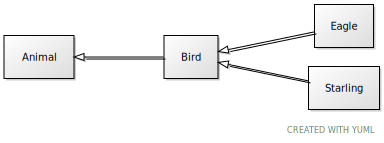

In [24]:
yuml("[Animal]^-[Bird],[Bird]^-[Eagle],[Bird]^-[Starling]")

### Aggregation vs Inheritance


If one object *has* or *owns* one or more objects, this is *not* inheritance.

For example, the boids example we saw few weeks ago, could be organised as an overall Model, which it owns several Boids,
and each Boid owns two 2-vectors, one for position and one for velocity.


### Aggregation in UML

The Boids situation can be represented thus:

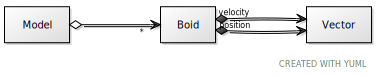

In [25]:
yuml("[Model]<>-*>[Boid],[Boid]position++->[Vector],[Boid]velocity++->[Vector]")

The open diamond indicates **Aggregation**, the closed diamond **composition**.
(A given boid might belong to multiple models, a given position vector is forever part of the corresponding Boid.)

The asterisk represents cardinality, a model may contain multiple Boids. This is a [one to many relationship](https://en.wikipedia.org/wiki/One-to-many_(data_model)). [Many to many relationship](https://en.wikipedia.org/wiki/Many-to-many_(data_model)) is shown with `*` on both sides.

### Refactoring to inheritance

💩**Smell**: Repeated code between two classes which are both ontologically subtypes of something

**before:**

In [26]:
class Person:
    def __init__(self, age, job):
        self.age = age
        self.job = job

    def birthday(self):
        self.age += 1


class Pet:
    def __init__(self, age, owner):
        self.age = age
        self.owner = owner

    def birthday(self):
        self.age += 1

**after:**

In [27]:
class Animal:
    def __init__(self, age):
        self.age = age

    def birthday(self):
        self.age += 1


class Person(Animal):
    def __init__(self, age, job):
        self.job = job
        super().__init__(age)


class Pet(Animal):
    def __init__(self, age, owner):
        self.owner = owner
        super().__init__(age)

### Polymorphism

Polymorphism refers to having different classes with the same method that does different things.

In [28]:
class Dog:
    def noise(self):
        return "Bark"


class Cat:
    def noise(self):
        return "Miaow"


class Pig:
    def noise(self):
        return "Oink"


class Cow:
    def noise(self):
        return "Moo"


animals = [Dog(), Dog(), Cat(), Pig(), Cow(), Cat()]
for animal in animals:
    print(animal.noise())

Bark
Bark
Miaow
Oink
Moo
Miaow





This will print "Bark Bark Miaow Oink Moo Miaow"

If two classes support the same method, but it does different things for the two classes, calling the method will invoke the version for
whatever class the object is an instance of.


## Polymorphism and Inheritance


Often, polymorphism uses multiple derived classes with a common base class.
However, [duck typing](https://en.wikipedia.org/wiki/Duck_typing) in Python means that all that is required is that the 
types support a common **Concept** (Such as iterable, or container, or, in this case, the
Noisy concept.)

A common base class is used where there is a likely **default** that you want several
of the derived classes to have.




In [29]:
class Animal:
    def noise(self):
        return "I don't make a noise."


class Dog(Animal):
    def noise(self):
        return "Bark"


class Worm(Animal):
    pass


class Poodle(Dog):
    pass


animals = [Dog(), Worm(), Pig(), Cow(), Poodle()]
for animal in animals:
    print(animal.noise())

Bark
I don't make a noise.
Oink
Moo
Bark


### Undefined Functions and Polymorphism


In the above example, we put in a dummy noise for Animals that don't know what type they are.

Instead, we can explicitly deliberately leave this undefined, and we get a crash if we access an undefined method.




In [30]:
class Animal:
    pass


class Worm(Animal):
    pass

In [31]:
Worm().noise()  # Generates error

AttributeError: 'Worm' object has no attribute 'noise'

### Refactoring to Polymorphism


💩**Smell**: a function uses a big set of `if` statements or a `case` statement to decide what to do:

**before:**

In [32]:
class Animal:
    def __init__(self, animal_kind):
        self.animal_kind = animal_kind

    def noise(self):
        if self.animal_kind == "Dog":
            return "Bark"
        if self.animal_kind == "Cat":
            return "Miaow"
        if self.animal_kind == "Cow":
            return "Moo"
        return "Growl"

which is better replaced by the code above.

### Interfaces and concepts


In C++, it is common to define classes which declare dummy methods, called "virtual" methods, which specify
the methods which derived classes must implement. Classes which define these methods, but which cannot be instantiated
into actual objects, are called "abstract base" classes or "interfaces".

Python's Duck Typing approach means explicitly declaring these is unnesssary: any class concept which implements
appropriately named methods will do. These as user-defined **concepts**, just as "iterable" or "container" are 
built-in Python concepts. A class is said to "implement an interface" or "satisfy a concept".


### Interfaces in UML

Interfaces implementation (a common ancestor that doesn't do anything but defines methods to share) in UML is indicated thus:

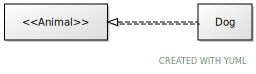

In [33]:
yuml("[<<Animal>>]^-.-[Dog]")

### Further UML


UML is a much larger diagram language than the aspects we've shown here.

* Message sequence charts show signals passing back and forth between objects ([Web Sequence Diagrams](https://www.websequencediagrams.com/)).

* Entity Relationship Diagrams can be used to show more general relationships between things in a system.


Read more about UML on Martin Fowler's [book about the topic](https://martinfowler.com/books/uml.html).
